# Лабораторная работа № 5

In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, roc_curve, plot_roc_curve
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Загружаем данные и смотрим на них:

In [6]:
original_data = pd.read_csv("diabetes.csv")
data = original_data
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


<AxesSubplot:xlabel='Outcome', ylabel='count'>

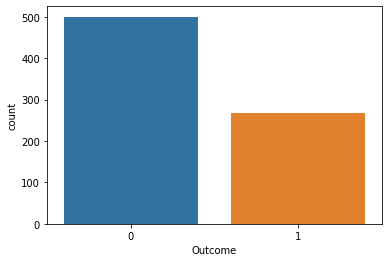

In [7]:
sns.countplot(x='Outcome',data=data)

При бинарной классификации более редкий класс обычно обозначается единицей; в данном случае датасет уже размечен соответствующим образом.

In [8]:
corr_matrix = data.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


Проанализировав данные, мы сделали следующие выводы:

*   среди данных по глюкозе, кровяному давлению, толщине кожи, инсулину и индексу массы тела встречается много очевидно ошибочных нулевых значений;
*   двузначное количество беременностей имеет тенденцию негативно сказываться на вашем здоровье.




Создадим модель для алгоритма классификации:

In [9]:
y = data['Outcome']
del data['Outcome']
del data['Insulin']
data['Pregnancies'].drop(np.where(data['Pregnancies'] % 10 !=0 )[0])
print(data['Pregnancies'])
df = pd.DataFrame({'Age': data['Age'], 'Pregnancies': data['Pregnancies'], 'Glucose': data['Glucose'], 'BMI': data['BMI'], 'DiabetesPedigreeFunction': data['DiabetesPedigreeFunction'], 'SkinThickness': data['SkinThickness']})

0       6
1       1
2       8
3       1
4       0
       ..
763    10
764     2
765     5
766     1
767     1
Name: Pregnancies, Length: 768, dtype: int64


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)


Создадим и обучим модель логистической регрессии.

In [11]:
logit = LogisticRegression(C=0.5, random_state=20, solver='liblinear')
logit.fit(X_train, y_train)

LogisticRegression(C=0.5, random_state=20, solver='liblinear')

Определим результат для тестовой выборки и оценим значения метрик.

In [12]:
y_predict = logit.predict(X_test)

In [13]:
print(f'\t accuracy = {accuracy_score(y_test, y_predict)},\n \
        precision = {precision_score(y_test, y_predict)},\n \
        recall = {recall_score(y_test, y_predict)},\n \
        roc_auc = {roc_auc_score(y_test, y_predict)}.')

	 accuracy = 0.7857142857142857,
         precision = 0.75,
         recall = 0.6,
         roc_auc = 0.7444444444444445.


## Задание 1. С помощью настройки гиперпараметров модели и работы с тренировочными данными - необходимо улучшить показатели метрик обучения модели.




Используя логистическую регрессию возможно определить целевые значения в виде вероятности принадлежности к классу.

In [14]:
y_predict_proba = logit.predict_proba(X_test)
print(y_predict_proba[:5])

[[0.62246131 0.37753869]
 [0.77994876 0.22005124]
 [0.7907716  0.2092284 ]
 [0.74219972 0.25780028]
 [0.59377487 0.40622513]]


Для каждого экземпляра данных получено по 2 значения: вероятность принадлежности к классу 0 и классу 1. С использованием этих данных возможно определить как будут изменяться метрики оценки обучения при разных пороговых значниях (threshold) вероятности принадлежности. По умолчанию threshold = 0.5. Значения метрик при этом значении приведены выше. Попробуем threshold = 0.1.

In [15]:
y_predict = []
for y in range(0, len(y_predict_proba)):
    if (y_predict_proba[y][1] > 0.1):
        y_predict.append(1)
    else:
        y_predict.append(0)

In [16]:
print(f'\t accuracy = {accuracy_score(y_test, y_predict)},\n \
        precision = {precision_score(y_test, y_predict)},\n \
        recall = {recall_score(y_test, y_predict)},\n \
        roc_auc = {roc_auc_score(y_test, y_predict)}.')

	 accuracy = 0.4025974025974026,
         precision = 0.3741496598639456,
         recall = 1.0,
         roc_auc = 0.5353535353535354.


Построим матрицу ошибок.

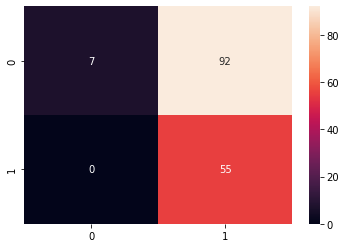

In [17]:
cm = confusion_matrix(y_test, y_predict)
f = sns.heatmap(cm, annot=True, fmt='d')
#По оси Х - предсказанные значения

Для разработанной модели также можно построить график ROC-AUC как по данным для обучения, так и тестовым данным.

C:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


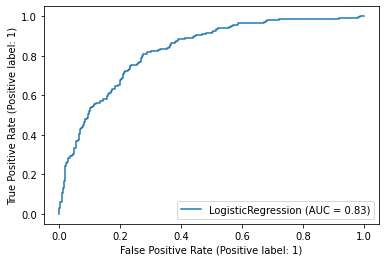

In [18]:
plot_roc_curve(logit, X_train, y_train)

C:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


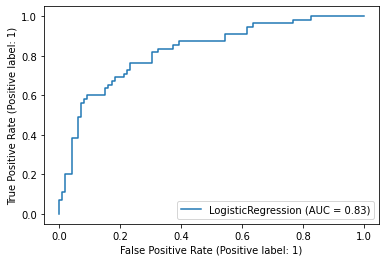

In [19]:
plot_roc_curve(logit, X_test, y_test)

## Задание 2. Изменяя параметр threshold с шагом 0.01 определить значения метрик accuracy, precision, recall, auc для каждого шага. Построить график изменений этих метрик.

C:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tuska\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tuska\AppData\Local\Pr

Text(0, 0.5, 'Значение метрик')

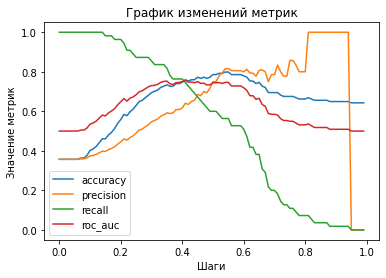

In [34]:
accuracy_y = []
precision_y = []
recall_y = []
roc_auc_y = []
for i in np.arange(0.0, 1.0, 0.01):

    y_predict = []
    for y in range(0, len(y_predict_proba)):
        if (y_predict_proba[y][1] > i):
            y_predict.append(1)
        else:
            y_predict.append(0)

    accuracy_y.append(accuracy_score(y_test, y_predict))
    precision_y.append(precision_score(y_test, y_predict))
    recall_y.append(recall_score(y_test, y_predict))
    roc_auc_y.append(roc_auc_score(y_test, y_predict))

plt.plot(np.arange(0.0, 1.0, 0.01), accuracy_y, label='accuracy')
plt.plot(np.arange(0.0, 1.0, 0.01), precision_y, label='precision')
plt.plot(np.arange(0.0, 1.0, 0.01), recall_y, label='recall')
plt.plot(np.arange(0.0, 1.0, 0.01), roc_auc_y, label='roc_auc')
plt.legend()
plt.title("График изменений метрик")
plt.xlabel("Шаги")
plt.ylabel("Значение метрик")
